In [1]:
from utils import *
import pickle
import pandas as pd
import networkx as nx
from backboning import backboning as bb
from node2vec import Node2Vec
import umap
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

def reconnect_singletons(df, df_bb, nodes):
   additional_edges = []
   missing_nodes = nodes - (set(df_bb["src"]) | set(df_bb["trg"]))
   for missing_node in missing_nodes:
      try:
         missing_node_edges = df[(df["src"] == missing_node) | (df["trg"] == missing_node)]
         additional_edges.append(pd.DataFrame(missing_node_edges.loc[missing_node_edges["score"].idxmax()]).T)
      except ValueError:
         pass
   return pd.concat([df_bb, pd.concat(additional_edges).drop_duplicates()])

def reconnect_components(df, df_bb):
   G = nx.from_pandas_edgelist(df_bb, source = "src", target = "trg")
   ccs = list(nx.connected_components(G))
   ccs = {n: i for i in range(len(ccs)) for n in ccs[i]}
   df["src_comp"] = df["src"].map(ccs)
   df["trg_comp"] = df["trg"].map(ccs)
   while df[["src_comp", "trg_comp"]].value_counts().size > 1:
      new_edge = df.loc[df.loc[df["src_comp"] != df["trg_comp"], "score"].idxmax()]
      df_bb = pd.concat([df_bb, pd.DataFrame(new_edge[["src", "trg", "nij", "score"]]).T])
      new_comp = new_edge[["src_comp", "trg_comp"]].min().min()
      old_comp = new_edge[["src_comp", "trg_comp"]].max().max()
      df.loc[df["src_comp"] == old_comp, "src_comp"] = new_comp
      df.loc[df["trg_comp"] == old_comp, "trg_comp"] = new_comp
   return df_bb

In [4]:
# Load CPM
with open('data/SRCA_4d.pickle', 'rb') as f:
    SRCA = pickle.load(f)

In [5]:
for year in SRCA:
    SRCA[year] = pd.DataFrame(np.where(SRCA[year] > 0, 1, 0), index=SRCA[year].index, columns=SRCA[year].columns)

In [6]:
SRCA[2012]

,0101,0102,0103,0104,0105,0106,0201,0202,0203,0204,...,9618,9619,9701,9702,9703,9704,9705,9706,9999,XXXX
country_id,,,,,,,,,,,,,,,,,,,,,
4,0,0,0,0,0,1,0,0,0,0,...,0,0,1,1,1,0,1,1,1,1
8,0,1,0,0,1,1,1,1,0,0,...,1,1,1,0,1,1,1,0,1,1
12,1,0,0,1,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,1
20,1,0,0,0,0,0,1,1,0,0,...,1,1,1,1,1,0,1,0,1,0
24,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
334,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
co_occur = SRCA[2012].T.dot(SRCA[2012]).unstack().reset_index()

In [8]:
co_occur.rename(columns = {"level_0": "src", "level_1": "trg", 0: "nij"}, inplace = True)

In [9]:
# Remove self-loops
co_occur = co_occur[co_occur["src"] != co_occur["trg"]]

# Remove XX and 99 (not discernible products)
co_occur = co_occur[(co_occur.src != "XXXX") & (~co_occur.src.str.startswith("99")) & (co_occur.trg != "XXXX") & (~co_occur.src.str.startswith("99"))]

In [10]:
co_occur.head(3)

,src,trg,nij
1,0101,0102,73
2,0101,0103,51
3,0101,0104,65


In [11]:
co_occur[["src", "trg"]] = co_occur[["src", "trg"]].apply(lambda x: x.str[:2])
co_occur = co_occur.groupby(["src", "trg"]).sum().reset_index()

# Remove self-loops
co_occur = co_occur[co_occur["src"] != co_occur["trg"]]

co_occur.head()

,src,trg,nij
1,01,02,4164
2,01,03,3981
3,01,04,4564
4,01,05,3212
5,01,06,1938


In [12]:
co_occur[((co_occur.src == "09") & (co_occur.trg == "02")) | ((co_occur.src == "02") & (co_occur.trg == "09"))]

,src,trg,nij
105,02,09,7349
777,09,02,7349


In [14]:
# Tee input required is a pandas dataframe with columns src, trg, and nij
# src and trg are the node ids of the origin an destination nodes
# nij is the weight of the edge, should be a discrete count
# If the network is undirected, if you have the src,trg edge you also MUST have the trg,src edge with the same weight
# A possible way to ensure that: df = pd.concat([df, df.rename(columns = {"src": "trg", "trg": "src"})])
#df = pd.read_csv(...)
#co_occur_indirected = pd.concat([co_occur, co_occur.rename(columns = {"src": "trg", "trg": "src"})])
co_occur_indirected = co_occur.copy()

# Change undirected to False if the network is undirected
df_nc = bb.noise_corrected(co_occur_indirected, undirected = True, calculate_p_value = False)

print("SCORES")
print(df_nc)
print(f"Min Score: {df_nc.score.min()}")
print(f"Max Score: {df_nc.score.max()}")
print(f"Null scores: {df_nc[df_nc.score.isna()].shape[0]}")
print()
print("P-VALUES")
#df_nc = bb.noise_corrected(co_occur_indirected, undirected = True, calculate_p_value = True)
#print(df_nc)
#print(f"Min Score: {df_nc.score.min()}")
#print(f"Max Score: {df_nc.score.max()}")
#print(f"Null scores: {df_nc[df_nc.score.isna()].shape[0]}")

     src trg    nij     ni.      n.j        n..  mean_prior_probability  \
1     01  02   4164  542247   911866  121216204                0.000034   
2     01  03   3981  542247   915201  121216204                0.000034   
3     01  04   4564  542247  1002314  121216204                0.000037   
4     01  05   3212  542247   719250  121216204                0.000027   
5     01  06   1938  542247   438643  121216204                0.000016   
...   ..  ..    ...     ...      ...        ...                     ...   
9306  97  93   2894  686672   540967  121216204                0.000025   
9307  97  94   4500  686672   745856  121216204                0.000035   
9308  97  95   4081  686672   701985  121216204                0.000033   
9309  97  96  10532  686672  1904159  121216204                0.000089   
9311  97  99    877  686672   136694  121216204                0.000006   

         kappa     score  
1     0.000245  0.010296  
2     0.000244 -0.014000  
3     0.000223  0.

In [15]:
kappa = 242432408 / (1083916 * 1824671)
 #((table["kappa"] * table["nij"]) - 1) / ((table["kappa"] * table["nij"]) + 1)
((kappa * 4164) - 1) / ((kappa * 4164) + 1)

-0.3241416894390052

<Axes: >

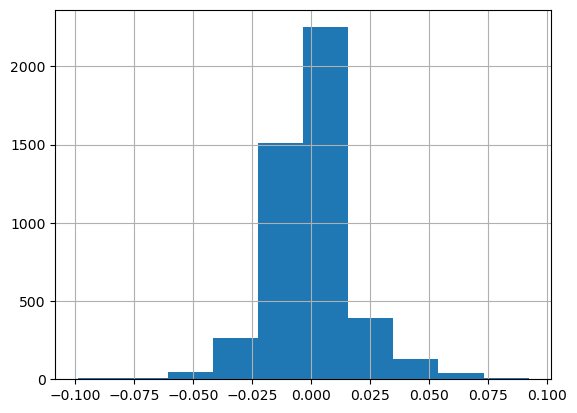

In [16]:
df_nc.score.hist()

In [17]:
# Useful to know how many nodes and edges you're dropping
# Change the values of start_threshold, end_threshold, and step to explore different options for the threshold
# The value you like should be plugged in the bb.thresholding function
# Change undirected to False if the network is undirected
x = 0.0021
start_threshold = 0
end_threshold = x
step = 0.0002
pd.DataFrame(data = bb.test_densities(df_nc, start_threshold, end_threshold, step, undirected = True), columns = ("threshold", "nodes", "nodes%", "edges", "edges%", "avgdeg", "avgdeg%"))

,threshold,nodes,nodes%,edges,edges%,avgdeg,avgdeg%
0,0.0000,97,100.000000,1125,24.162371,23.195876,0.241624
1,0.0002,96,98.969072,491,10.545533,10.229167,0.106554
2,0.0004,93,95.876289,382,8.204467,8.215054,0.085573
3,0.0006,91,93.814433,321,6.894330,7.054945,0.073489
4,0.0008,90,92.783505,290,6.228522,6.444444,0.067130
5,0.0010,87,89.690722,265,5.691581,6.091954,0.063458
6,0.0012,83,85.567010,245,5.262027,5.903614,0.061496
7,0.0014,83,85.567010,227,4.875430,5.469880,0.056978
8,0.0016,81,83.505155,211,4.531787,5.209877,0.054270
9,0.0018,78,80.412371,200,4.295533,5.128205,0.053419


In [18]:
df_nc_bb = bb.thresholding(df_nc, 0.001)

df_nc_bb = reconnect_singletons(df_nc, df_nc_bb, set(co_occur_indirected["src"]) | set(co_occur_indirected["trg"]))
df_nc_bb = reconnect_components(df_nc, df_nc_bb)

In [19]:
df_nc_bb

,src,trg,nij,score,sdev_cij
1,01,02,4164,0.010296,NaN
3,01,04,4564,0.008871,NaN
9,01,10,3269,0.011383,NaN
22,01,23,3629,0.005672,NaN
35,01,36,2155,0.00788,NaN
...,...,...,...,...,...
2698,28,81,35694,0.06616,351.42635
6969,72,84,228011,0.038682,15424.537414
6581,68,84,122973,0.035034,52962.587393
8037,84,85,464714,0.076996,29111.991666


In [ ]:
#df_nc_bb.to_csv("test_001.csv", index=False)

In [33]:
G = nx.Graph(nx.from_pandas_edgelist(df_nc_bb, source = "src", target = "trg", edge_attr=["nij", "score"]))

In [ ]:
# Node2Vec 
node2vec = Node2Vec(G, dimensions=8, walk_length=10, num_walks=200, p=1, q=1, weight_key='nij', workers=4)
model = node2vec.fit(window=4, min_count=1, batch_words=4)

Computing transition probabilities: 100%|██████████| 97/97 [00:00<00:00, 2199.50it/s]


In [37]:
# Get list of country names and their vectors
countries = list(model.wv.vocab.keys())
vectors = np.array([model.wv[c] for c in countries])

reducer = umap.UMAP(n_neighbors=5, min_dist=0.9)
vectors_2d = reducer.fit_transform(vectors)

c:\Users\ginof\anaconda3\envs\thesis\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


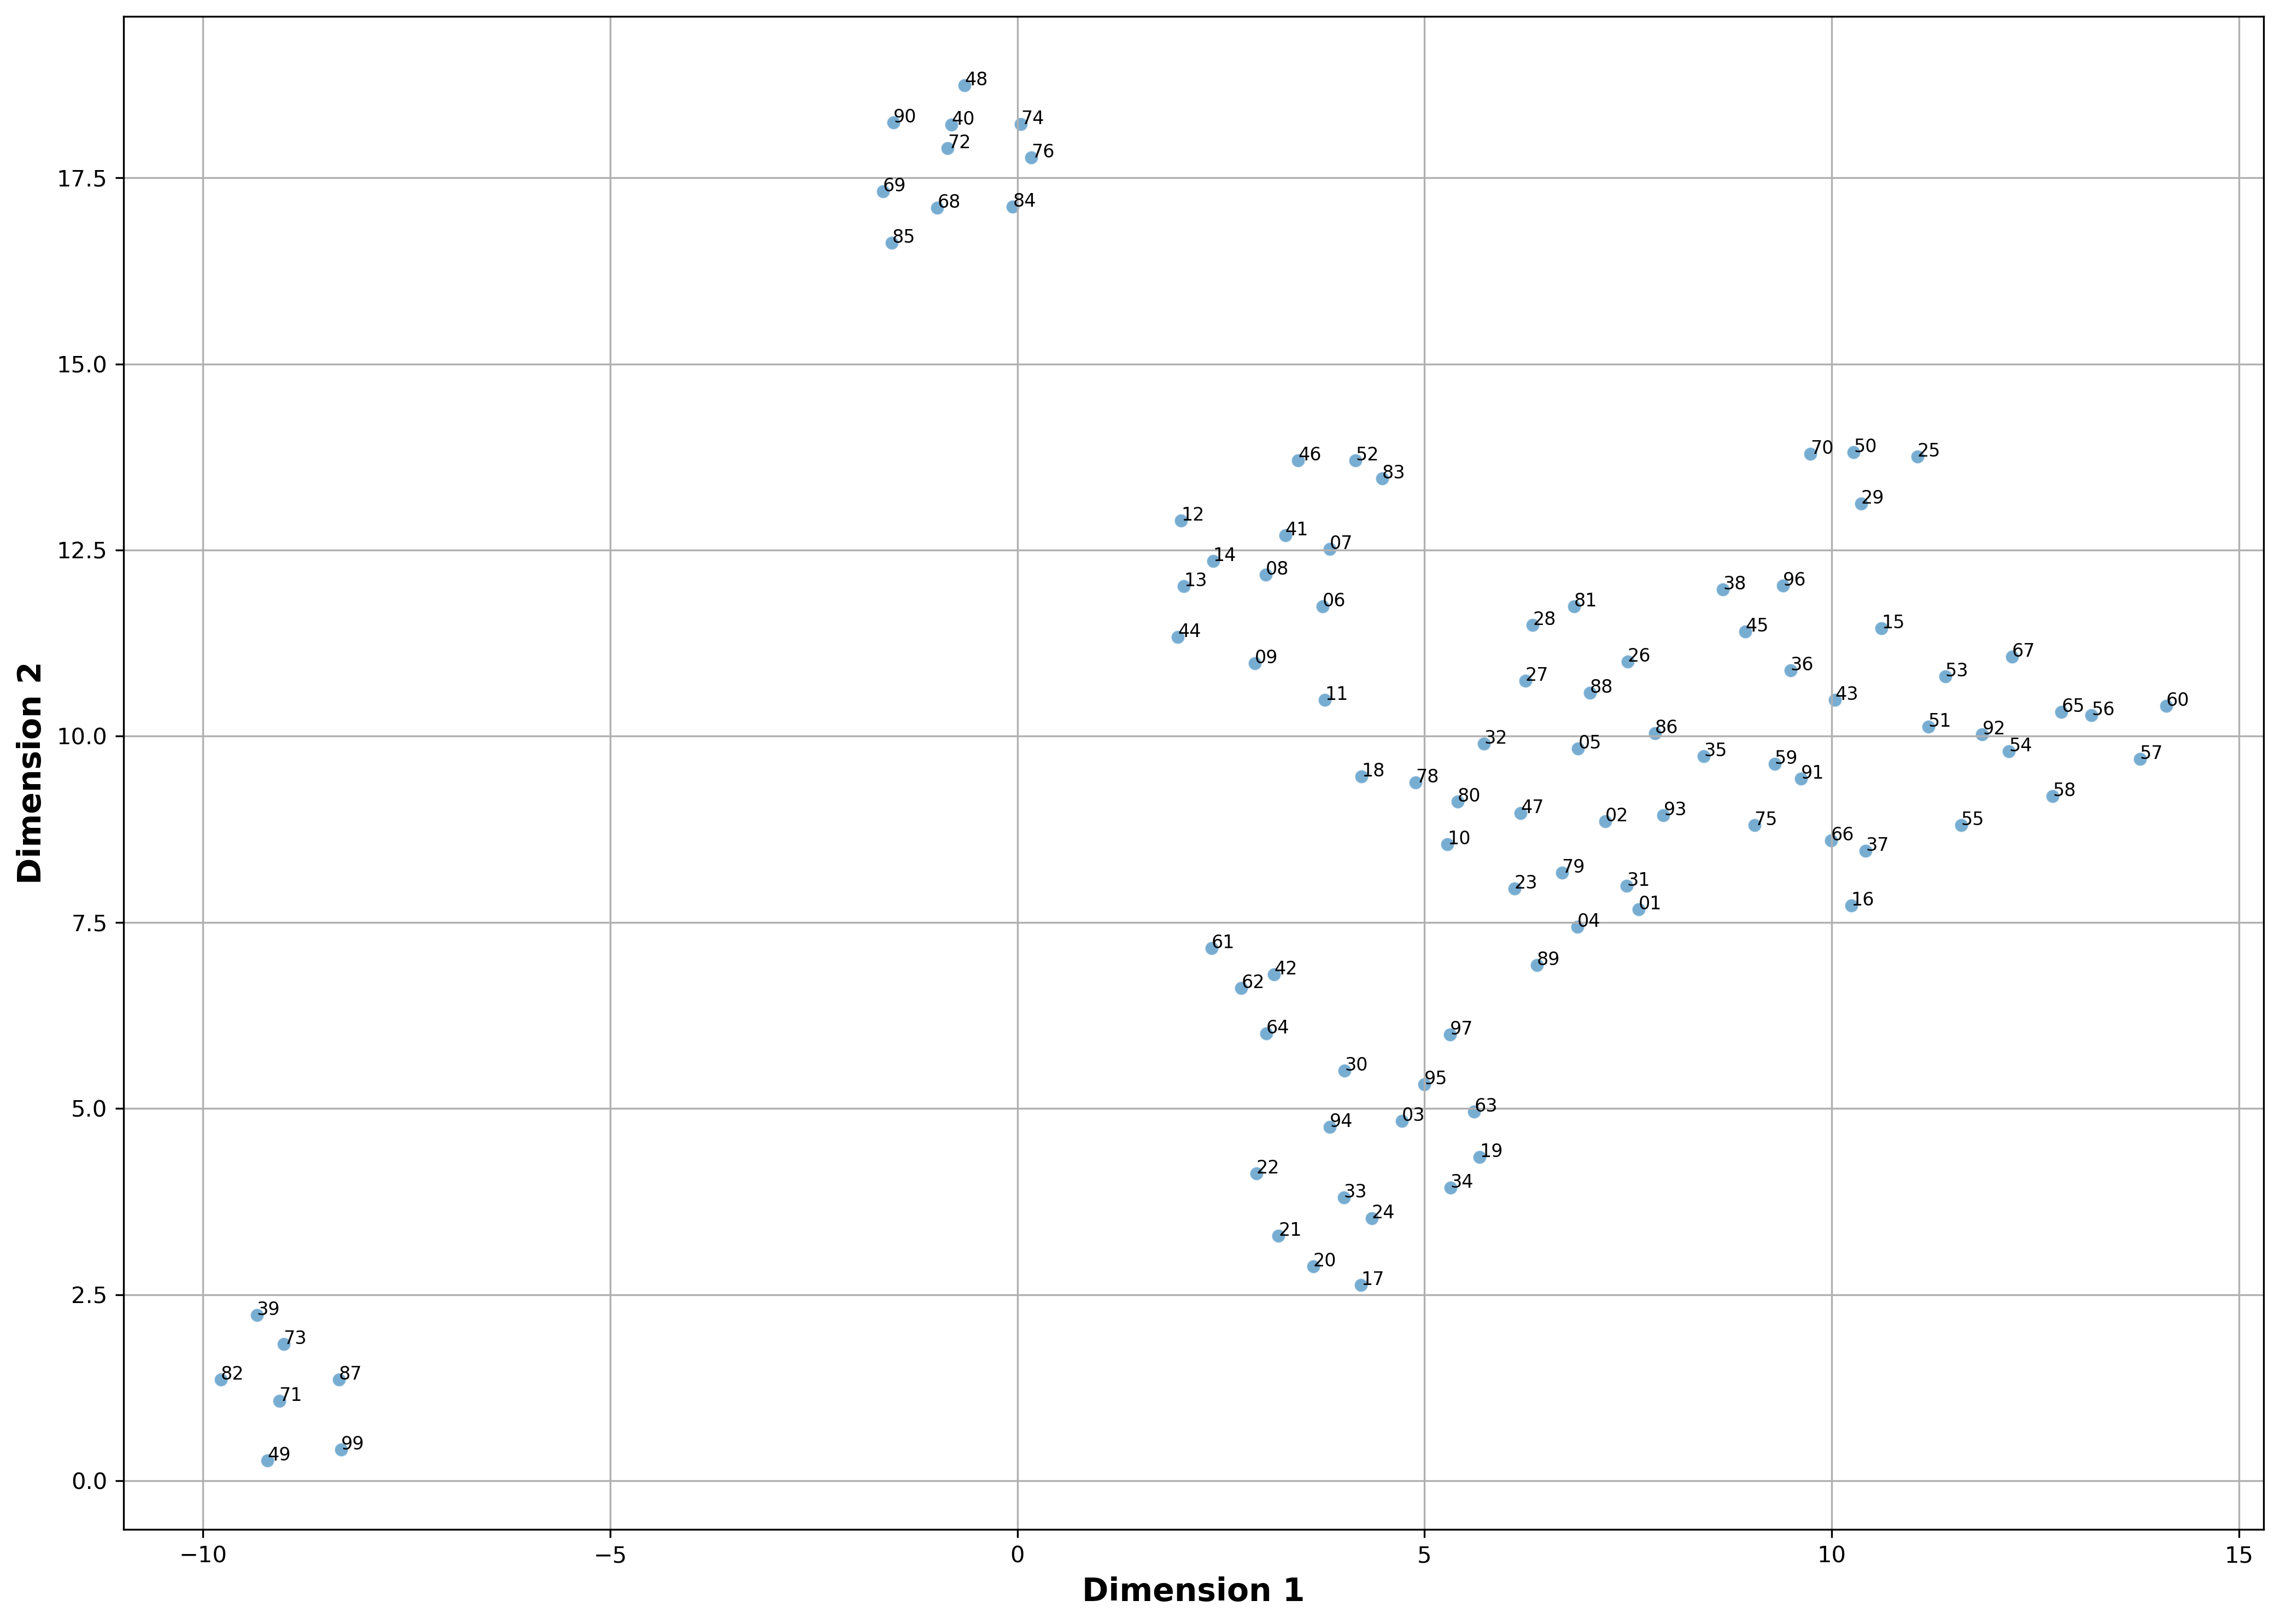

In [41]:
fig, ax = plt.subplots(figsize=(14, 10), dpi=300)

sns.scatterplot(x=vectors_2d[:, 0], y=vectors_2d[:, 1], alpha=0.6, ax=ax)

# Create all text labels
texts = [
    plt.text(vectors_2d[i, 0], vectors_2d[i, 1], country, fontsize=8)
    for i, country in enumerate(countries)
]

plt.xlabel("Dimension 1", fontsize=14, fontweight='bold')
plt.ylabel("Dimension 2", fontsize=14, fontweight='bold')
plt.grid(True)
plt.tight_layout()
# Auto-adjust to avoid overlap
#adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5), ax=ax, expand_axes=True)
plt.show()


In [ ]:
model.wv.save_word2vec_format('../data/product-space-embeddings.vec')  # save

In [45]:
pd.read_csv("product-space-embeddings.vec", sep=" ", skiprows=1, header=None)

,0,1,2,3,4,5,6,7,8
0,84,3.590618,-0.158279,-1.080229,-1.613365,1.331600,-1.672022,1.125604,-2.843426
1,81,0.504648,-1.317165,0.297232,1.819777,-1.614453,-1.673071,0.628840,-0.593139
2,53,-0.584089,-0.940602,0.703910,-0.089121,-1.700154,-2.008277,0.835993,0.768939
3,50,-1.587679,-1.443693,-0.788479,-0.930189,-0.750725,-1.404183,2.809738,0.351336
4,51,-0.008854,-0.704956,1.222725,0.117330,-1.179844,-1.952838,0.487984,0.513840
...,...,...,...,...,...,...,...,...,...
92,83,-2.883259,-2.097279,1.025449,-1.281419,0.336444,-1.544861,-1.842116,-0.709235
93,32,0.578192,-2.535567,0.743674,1.020128,-1.441833,0.754876,1.739675,0.647837
94,52,-2.680203,-2.133430,0.852611,-1.135648,0.290580,-1.365181,-1.968817,-0.667619
95,49,1.834217,-1.181582,-1.745540,-0.762161,0.580439,1.326029,-0.450671,-1.209676


In [6]:
for year in SRCA:
    SRCA[year] = pd.DataFrame(np.where(SRCA[year] > 0, 1, 0), index=SRCA[year].index, columns=SRCA[year].columns)
    co_occur = SRCA[year].T.dot(SRCA[year]).unstack().reset_index()
    co_occur.rename(columns = {"level_0": "src", "level_1": "trg", 0: "nij"}, inplace = True)
    # Remove self-loops
    co_occur = co_occur[co_occur["src"] != co_occur["trg"]]

    # Remove XX and 99 (not discernible products)
    co_occur = co_occur[(co_occur.src != "XXXX") & (~co_occur.src.str.startswith("99")) & (co_occur.trg != "XXXX") & (~co_occur.src.str.startswith("99"))]
    co_occur[["src", "trg"]] = co_occur[["src", "trg"]].apply(lambda x: x.str[:2])
    co_occur = co_occur.groupby(["src", "trg"]).sum().reset_index()

    # Remove self-loops
    co_occur = co_occur[co_occur["src"] != co_occur["trg"]]

    co_occur_indirected = co_occur.copy()

    # Change undirected to False if the network is undirected
    df_nc = bb.noise_corrected(co_occur_indirected, undirected = True, calculate_p_value = False)

    x = 0.0021
    start_threshold = 0
    end_threshold = x
    step = 0.0002
    print(year)
    print(pd.DataFrame(data = bb.test_densities(df_nc, start_threshold, end_threshold, step, undirected = True),
                        columns = ("threshold", "nodes", "nodes%", "edges", "edges%", "avgdeg", "avgdeg%")))
    input("Continue...")

    df_nc_bb = bb.thresholding(df_nc, 0.001)

    df_nc_bb = reconnect_singletons(df_nc, df_nc_bb, set(co_occur_indirected["src"]) | set(co_occur_indirected["trg"]))
    df_nc_bb = reconnect_components(df_nc, df_nc_bb)

    G = nx.Graph(nx.from_pandas_edgelist(df_nc_bb, source = "src", target = "trg", edge_attr=["nij", "score"]))
    # Node2Vec 
    node2vec = Node2Vec(G, dimensions=8, walk_length=10, num_walks=200, p=1, q=1, weight_key='nij', workers=4)
    model = node2vec.fit(window=4, min_count=1, batch_words=4)

    model.wv.save_word2vec_format(f'./data/product-space-embeddings-{year}.vec')  # save

2012
    threshold  nodes      nodes%  edges     edges%     avgdeg   avgdeg%
0      0.0000     97  100.000000   1125  24.162371  23.195876  0.241624
1      0.0002     96   98.969072    491  10.545533  10.229167  0.106554
2      0.0004     93   95.876289    382   8.204467   8.215054  0.085573
3      0.0006     91   93.814433    321   6.894330   7.054945  0.073489
4      0.0008     90   92.783505    290   6.228522   6.444444  0.067130
5      0.0010     87   89.690722    265   5.691581   6.091954  0.063458
6      0.0012     83   85.567010    245   5.262027   5.903614  0.061496
7      0.0014     83   85.567010    227   4.875430   5.469880  0.056978
8      0.0016     81   83.505155    211   4.531787   5.209877  0.054270
9      0.0018     78   80.412371    200   4.295533   5.128205  0.053419
10     0.0020     78   80.412371    192   4.123711   4.923077  0.051282


Computing transition probabilities: 100%|██████████| 97/97 [00:00<00:00, 2448.28it/s]


2013
    threshold  nodes      nodes%  edges     edges%     avgdeg   avgdeg%
0      0.0000     97  100.000000   1119  24.033505  23.072165  0.240335
1      0.0002     95   97.938144    381   8.182990   8.021053  0.083553
2      0.0004     90   92.783505    287   6.164089   6.377778  0.066435
3      0.0006     89   91.752577    240   5.154639   5.393258  0.056180
4      0.0008     83   85.567010    208   4.467354   5.012048  0.052209
5      0.0010     82   84.536082    189   4.059278   4.609756  0.048018
6      0.0012     81   83.505155    173   3.715636   4.271605  0.044496
7      0.0014     78   80.412371    159   3.414948   4.076923  0.042468
8      0.0016     73   75.257732    145   3.114261   3.972603  0.041381
9      0.0018     71   73.195876    135   2.899485   3.802817  0.039613
10     0.0020     68   70.103093    128   2.749141   3.764706  0.039216


Computing transition probabilities: 100%|██████████| 97/97 [00:00<00:00, 3379.81it/s]


2014
    threshold  nodes      nodes%  edges     edges%     avgdeg   avgdeg%
0      0.0000     97  100.000000   1121  24.076460  23.113402  0.240765
1      0.0002     92   94.845361    341   7.323883   7.413043  0.077219
2      0.0004     87   89.690722    255   5.476804   5.862069  0.061063
3      0.0006     82   84.536082    214   4.596220   5.219512  0.054370
4      0.0008     75   77.319588    183   3.930412   4.880000  0.050833
5      0.0010     71   73.195876    165   3.543814   4.647887  0.048415
6      0.0012     70   72.164948    150   3.221649   4.285714  0.044643
7      0.0014     69   71.134021    137   2.942440   3.971014  0.041365
8      0.0016     69   71.134021    127   2.727663   3.681159  0.038345
9      0.0018     65   67.010309    114   2.448454   3.507692  0.036538
10     0.0020     62   63.917526    106   2.276632   3.419355  0.035618


Computing transition probabilities: 100%|██████████| 97/97 [00:00<00:00, 4988.50it/s]


2015
    threshold  nodes      nodes%  edges     edges%     avgdeg   avgdeg%
0      0.0000     97  100.000000   1106  23.754296  22.804124  0.237543
1      0.0002     89   91.752577    303   6.507732   6.808989  0.070927
2      0.0004     79   81.443299    230   4.939863   5.822785  0.060654
3      0.0006     77   79.381443    195   4.188144   5.064935  0.052760
4      0.0008     74   76.288660    166   3.565292   4.486486  0.046734
5      0.0010     71   73.195876    149   3.200172   4.197183  0.043721
6      0.0012     69   71.134021    138   2.963918   4.000000  0.041667
7      0.0014     69   71.134021    129   2.770619   3.739130  0.038949
8      0.0016     66   68.041237    118   2.534364   3.575758  0.037247
9      0.0018     66   68.041237    108   2.319588   3.272727  0.034091
10     0.0020     66   68.041237    101   2.169244   3.060606  0.031881


Computing transition probabilities: 100%|██████████| 97/97 [00:00<00:00, 4947.20it/s]


2016
    threshold  nodes      nodes%  edges     edges%     avgdeg   avgdeg%
0      0.0000     97  100.000000   1105  23.732818  22.783505  0.237328
1      0.0002     88   90.721649    310   6.658076   7.045455  0.073390
2      0.0004     77   79.381443    235   5.047251   6.103896  0.063582
3      0.0006     73   75.257732    191   4.102234   5.232877  0.054509
4      0.0008     71   73.195876    166   3.565292   4.676056  0.048709
5      0.0010     70   72.164948    144   3.092784   4.114286  0.042857
6      0.0012     67   69.072165    129   2.770619   3.850746  0.040112
7      0.0014     64   65.979381    117   2.512887   3.656250  0.038086
8      0.0016     61   62.886598    107   2.298110   3.508197  0.036544
9      0.0018     59   60.824742    101   2.169244   3.423729  0.035664
10     0.0020     58   59.793814     95   2.040378   3.275862  0.034124


Computing transition probabilities: 100%|██████████| 97/97 [00:00<00:00, 3658.24it/s]


2017
    threshold  nodes      nodes%  edges     edges%     avgdeg   avgdeg%
0      0.0000     97  100.000000   1124  24.140893  23.175258  0.241409
1      0.0002     87   89.690722    306   6.572165   7.034483  0.073276
2      0.0004     82   84.536082    234   5.025773   5.707317  0.059451
3      0.0006     79   81.443299    192   4.123711   4.860759  0.050633
4      0.0008     75   77.319588    163   3.500859   4.346667  0.045278
5      0.0010     74   76.288660    144   3.092784   3.891892  0.040541
6      0.0012     72   74.226804    130   2.792096   3.611111  0.037616
7      0.0014     68   70.103093    116   2.491409   3.411765  0.035539
8      0.0016     65   67.010309    109   2.341065   3.353846  0.034936
9      0.0018     64   65.979381    102   2.190722   3.187500  0.033203
10     0.0020     60   61.855670     95   2.040378   3.166667  0.032986


Computing transition probabilities: 100%|██████████| 97/97 [00:00<00:00, 5633.68it/s]


2018
    threshold  nodes      nodes%  edges     edges%     avgdeg   avgdeg%
0      0.0000     97  100.000000   1127  24.205326  23.237113  0.242053
1      0.0002     88   90.721649    305   6.550687   6.931818  0.072206
2      0.0004     79   81.443299    227   4.875430   5.746835  0.059863
3      0.0006     73   75.257732    188   4.037801   5.150685  0.053653
4      0.0008     69   71.134021    161   3.457904   4.666667  0.048611
5      0.0010     66   68.041237    140   3.006873   4.242424  0.044192
6      0.0012     61   62.886598    128   2.749141   4.196721  0.043716
7      0.0014     58   59.793814    115   2.469931   3.965517  0.041307
8      0.0016     57   58.762887    107   2.298110   3.754386  0.039108
9      0.0018     55   56.701031    102   2.190722   3.709091  0.038636
10     0.0020     55   56.701031     99   2.126289   3.600000  0.037500


Computing transition probabilities: 100%|██████████| 97/97 [00:00<00:00, 4728.09it/s]


2019
    threshold  nodes      nodes%  edges     edges%     avgdeg   avgdeg%
0      0.0000     97  100.000000   1117  23.990550  23.030928  0.239905
1      0.0002     87   89.690722    287   6.164089   6.597701  0.068726
2      0.0004     79   81.443299    214   4.596220   5.417722  0.056435
3      0.0006     72   74.226804    182   3.908935   5.055556  0.052662
4      0.0008     67   69.072165    156   3.350515   4.656716  0.048507
5      0.0010     62   63.917526    139   2.985395   4.483871  0.046707
6      0.0012     60   61.855670    128   2.749141   4.266667  0.044444
7      0.0014     59   60.824742    115   2.469931   3.898305  0.040607
8      0.0016     56   57.731959    105   2.255155   3.750000  0.039062
9      0.0018     53   54.639175     96   2.061856   3.622642  0.037736
10     0.0020     53   54.639175     90   1.932990   3.396226  0.035377


Computing transition probabilities: 100%|██████████| 97/97 [00:00<00:00, 4962.70it/s]


2020
    threshold  nodes      nodes%  edges     edges%     avgdeg   avgdeg%
0      0.0000     97  100.000000   1109  23.818729  22.865979  0.238187
1      0.0002     90   92.783505    309   6.636598   6.866667  0.071528
2      0.0004     82   84.536082    226   4.853952   5.512195  0.057419
3      0.0006     76   78.350515    186   3.994845   4.894737  0.050987
4      0.0008     75   77.319588    164   3.522337   4.373333  0.045556
5      0.0010     73   75.257732    144   3.092784   3.945205  0.041096
6      0.0012     67   69.072165    129   2.770619   3.850746  0.040112
7      0.0014     63   64.948454    116   2.491409   3.682540  0.038360
8      0.0016     63   64.948454    108   2.319588   3.428571  0.035714
9      0.0018     61   62.886598    102   2.190722   3.344262  0.034836
10     0.0020     59   60.824742     95   2.040378   3.220339  0.033545


Computing transition probabilities: 100%|██████████| 97/97 [00:00<00:00, 4623.79it/s]


2021
    threshold  nodes      nodes%  edges     edges%     avgdeg   avgdeg%
0      0.0000     97  100.000000   1122  24.097938  23.134021  0.240979
1      0.0002     90   92.783505    319   6.851375   7.088889  0.073843
2      0.0004     82   84.536082    231   4.961340   5.634146  0.058689
3      0.0006     76   78.350515    191   4.102234   5.026316  0.052357
4      0.0008     72   74.226804    170   3.651203   4.722222  0.049190
5      0.0010     70   72.164948    153   3.286082   4.371429  0.045536
6      0.0012     69   71.134021    138   2.963918   4.000000  0.041667
7      0.0014     66   68.041237    128   2.749141   3.878788  0.040404
8      0.0016     65   67.010309    122   2.620275   3.753846  0.039103
9      0.0018     63   64.948454    114   2.448454   3.619048  0.037698
10     0.0020     61   62.886598    108   2.319588   3.540984  0.036885


Computing transition probabilities: 100%|██████████| 97/97 [00:00<00:00, 4600.53it/s]


2022
    threshold  nodes      nodes%  edges     edges%     avgdeg   avgdeg%
0      0.0000     97  100.000000   1124  24.140893  23.175258  0.241409
1      0.0002     88   90.721649    315   6.765464   7.159091  0.074574
2      0.0004     80   82.474227    235   5.047251   5.875000  0.061198
3      0.0006     75   77.319588    199   4.274055   5.306667  0.055278
4      0.0008     72   74.226804    169   3.629725   4.694444  0.048900
5      0.0010     68   70.103093    151   3.243127   4.441176  0.046262
6      0.0012     63   64.948454    134   2.878007   4.253968  0.044312
7      0.0014     61   62.886598    125   2.684708   4.098361  0.042691
8      0.0016     61   62.886598    118   2.534364   3.868852  0.040301
9      0.0018     59   60.824742    110   2.362543   3.728814  0.038842
10     0.0020     58   59.793814    105   2.255155   3.620690  0.037716


Computing transition probabilities: 100%|██████████| 97/97 [00:00<00:00, 4625.95it/s]


In [7]:
product_space_embeddings = {}

for year in SRCA:
    product_space_embeddings[year] = pd.read_csv(f'./data/product-space-embeddings-{year}.vec', sep=" ", skiprows=1, header=None)

# Write SRCA
with open('data/product_space_embeddings.pickle', 'wb') as f:
    pickle.dump(product_space_embeddings, f)